# Exercises #

In [66]:
import torch
import requests
import zipfile
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from pathlib import Path
from torch import nn
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm.auto import tqdm

1. **Reduce Regularization** - You may have implemented many different ways to prevent overfitting and this is affecting the model because you have set the restrictions too tight for it to actually learn
2. **Add More Layers/Neurons** - Simply giving the model more capacity to learn by adding more neurons and layers to the model. This gives it more computational power to detect patterns.
3. **Add More Epochs** - Giving more time for the model to learn and training it for longer gives the model more opportunity to observe and capture patters in the data.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

In [4]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Number of Directories = {len(dirnames)} | Number of Files = {len(filenames)} | Located in {dirpath}")

In [5]:
walk_through_dir(data_path)

Number of Directories = 2 | Number of Files = 1 | Located in data
Number of Directories = 0 | Number of Files = 1 | Located in data\custom_image
Number of Directories = 2 | Number of Files = 0 | Located in data\pizza_steak_sushi
Number of Directories = 3 | Number of Files = 0 | Located in data\pizza_steak_sushi\test
Number of Directories = 0 | Number of Files = 25 | Located in data\pizza_steak_sushi\test\pizza
Number of Directories = 0 | Number of Files = 19 | Located in data\pizza_steak_sushi\test\steak
Number of Directories = 0 | Number of Files = 31 | Located in data\pizza_steak_sushi\test\sushi
Number of Directories = 3 | Number of Files = 0 | Located in data\pizza_steak_sushi\train
Number of Directories = 0 | Number of Files = 78 | Located in data\pizza_steak_sushi\train\pizza
Number of Directories = 0 | Number of Files = 75 | Located in data\pizza_steak_sushi\train\steak
Number of Directories = 0 | Number of Files = 72 | Located in data\pizza_steak_sushi\train\sushi


In [6]:
train_path = image_path/'train'
test_path = image_path/'test'

train_path, test_path

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Class of Image: steak
Image Location: data\pizza_steak_sushi\train\steak\2222018.jpg
Image Height: 512
Image Width: 512


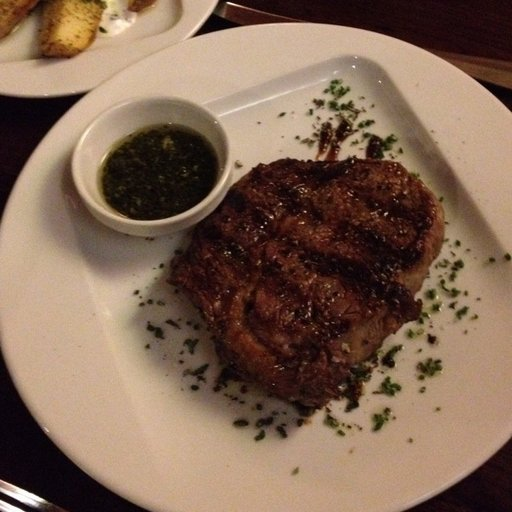

In [7]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_path_image = random.choice(image_path_list)

image_class = random_path_image.parent.stem
img = Image.open(random_path_image)

print(f"Class of Image: {image_class}")
print(f"Image Location: {random_path_image}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")

img

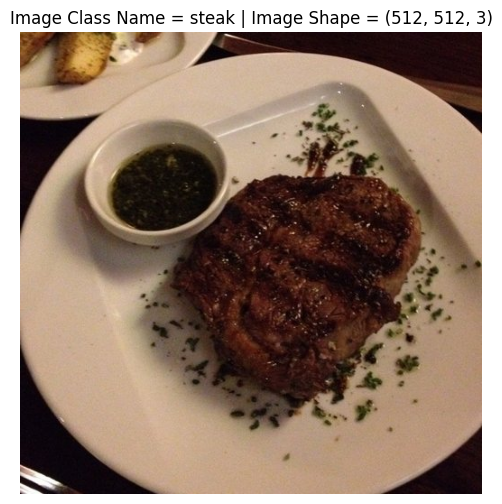

In [8]:
img_as_numpy = np.asarray(img)
plt.figure(figsize=(6,6))
plt.imshow(img_as_numpy)
plt.title(f"Image Class Name = {image_class} | Image Shape = {img_as_numpy.shape}")
plt.axis("off");

In [9]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [10]:
def plot_transform(image_path, transform, n=3, seed=12):
    random.seed(seed)
    random_image_path = random.sample(image_path, k=n)
    for image in random_image_path:
        with Image.open(image) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis("off")
        
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Size: {transformed_image.shape}")
            ax[1].axis("off")
        
            fig.suptitle(f"Class: {image.parent.stem}", fontsize=14)

Error in callback <function _draw_all_if_interactive at 0x000002735AFBE980> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

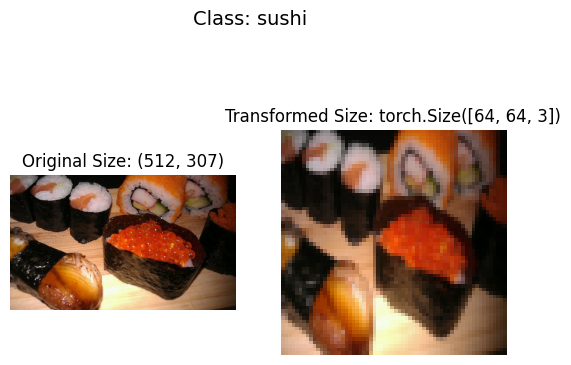

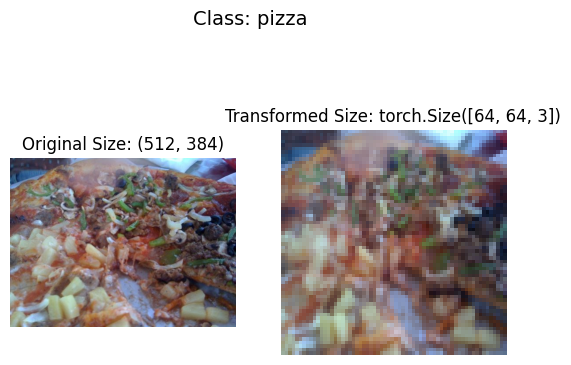

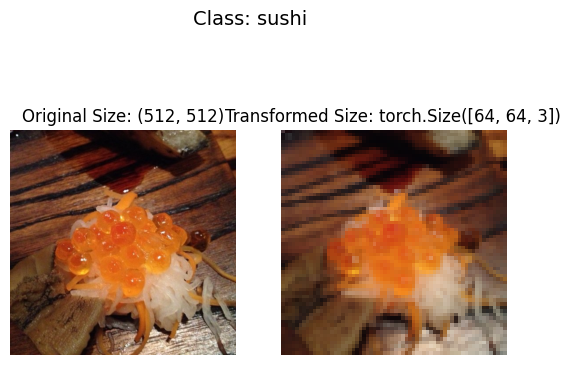

In [11]:
plot_transform(image_path_list, simple_transform)

In [12]:
train_data = datasets.ImageFolder(train_path, simple_transform)
test_data = datasets.ImageFolder(test_path, simple_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [13]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
len(train_data), len(test_data)

(225, 75)

In [16]:
train_dataloader = DataLoader(train_data, batch_size=1, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, num_workers=os.cpu_count(), shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27364e92ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x27364a17c80>)

In [17]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [18]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1,),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*16*16, output_shape),
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))

In [19]:
model_0 = TinyVGG(3, 10, len(train_data.classes))
model_0.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [20]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device):

    # Set to train
    model.train()
    # Initialize train loss and accuracy variables
    train_loss, train_acc = 0,0

    # Loop through dataloader
    for batch, (X,y) in enumerate(dataloader):
        # Send to device
        X,y = X.to(device), y.to(device)
        # Forward Pass
        logits = model(X)
        # Calc & Accumulate Loss
        loss = loss_fn(logits, y)
        train_loss += loss
        # Optimize Grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # Optimizer Step
        optimizer.step()

        # Don't need probabilities when calculating accuracy - so no softmax req
        pred_labels = logits.argmax(dim=1)
        # Check how many 1-0 with pred_labels == y
        # Sum the amount of truth and then transfer to regular python int 
        # We're using PyTorch's item() not Python's item() 
        # Divide by the length of the labels 
        train_acc += ((pred_labels == y).sum().item() / (len(pred_labels)))


    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc 

In [21]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device = device):

    # Set to test
    model.eval()
    # Initialize test loss and accuracy variables
    test_loss, test_acc = 0,0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss
            pred_labels = logits.argmax(dim=1)
            test_acc += ((pred_labels == y).sum().item() / (len(pred_labels)))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [22]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epochs: int = 5):

    # Results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)

        print(f"Epoch: {epoch+1} | " 
             f"Train Loss: {train_loss:.4f} | "
             f"Train Accuracy: {train_acc:.4f} | "
             f"Test Loss: {test_loss:.4f} | "
             f"Test Accuracy: {test_acc:.4f}"
             )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

train_results = train(model=model_0,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 141, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20

train_results = train(model=model_0,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=EPOCHS)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 50

train_results = train(model=model_0,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=EPOCHS)

In [25]:
model_1 = TinyVGG(3, 20, len(train_data.classes))
model_1.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20

train_results = train(model=model_1,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=EPOCHS)

In [34]:
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi_20"
if image_path.is_dir():
    print(f"{image_path} directory already exists.")
else: 
    print(f"{image_path} can't be found - creating image path")
    data_path.mkdir(parents=True, exist_ok=True)
    # Downloads pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading Data")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping Data")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi_20 can't be found - creating image path
Unzipping Data


In [35]:
walk_through_dir(image_path)

Number of Directories = 2 | Number of Files = 0 | Located in data\pizza_steak_sushi_20
Number of Directories = 3 | Number of Files = 0 | Located in data\pizza_steak_sushi_20\test
Number of Directories = 0 | Number of Files = 46 | Located in data\pizza_steak_sushi_20\test\pizza
Number of Directories = 0 | Number of Files = 58 | Located in data\pizza_steak_sushi_20\test\steak
Number of Directories = 0 | Number of Files = 46 | Located in data\pizza_steak_sushi_20\test\sushi
Number of Directories = 3 | Number of Files = 0 | Located in data\pizza_steak_sushi_20\train
Number of Directories = 0 | Number of Files = 154 | Located in data\pizza_steak_sushi_20\train\pizza
Number of Directories = 0 | Number of Files = 146 | Located in data\pizza_steak_sushi_20\train\steak
Number of Directories = 0 | Number of Files = 150 | Located in data\pizza_steak_sushi_20\train\sushi


In [41]:
train_data_path_20 = image_path/'train'
test_data_path_20 = image_path/'test'

train_data_path_20, test_data_path_20

(WindowsPath('data/pizza_steak_sushi_20/train'),
 WindowsPath('data/pizza_steak_sushi_20/test'))

In [44]:
train_dataset_20 = datasets.ImageFolder(root=train_data_path_20, transform=simple_transform)
test_dataset_20 = datasets.ImageFolder(root=test_data_path_20, transform=simple_transform)

In [45]:
train_dataloader_20 = DataLoader(train_dataset_20, batch_size=32, shuffle=True)
test_dataloader_20 = DataLoader(test_dataset_20, batch_size=32)

In [52]:
model_2 = TinyVGG(3, 10, len(train_data.classes))
model_2.to(device)

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 30

train_results = train(model=model_2,
                     train_dataloader=train_dataloader_20,
                     test_dataloader=test_dataloader_20,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.7726 | Train Accuracy: 0.6771 | Test Loss: 0.8589 | Test Accuracy: 0.6193
Epoch: 2 | Train Loss: 0.7625 | Train Accuracy: 0.6708 | Test Loss: 0.8403 | Test Accuracy: 0.5966
Epoch: 3 | Train Loss: 0.7770 | Train Accuracy: 0.6417 | Test Loss: 0.8268 | Test Accuracy: 0.5773
Epoch: 4 | Train Loss: 0.7339 | Train Accuracy: 0.6771 | Test Loss: 0.8916 | Test Accuracy: 0.5926
Epoch: 5 | Train Loss: 0.6993 | Train Accuracy: 0.7021 | Test Loss: 0.8251 | Test Accuracy: 0.5869
Epoch: 6 | Train Loss: 0.6671 | Train Accuracy: 0.7354 | Test Loss: 0.8379 | Test Accuracy: 0.6250
Epoch: 7 | Train Loss: 0.6362 | Train Accuracy: 0.7479 | Test Loss: 0.8608 | Test Accuracy: 0.6318
Epoch: 8 | Train Loss: 0.6014 | Train Accuracy: 0.7688 | Test Loss: 0.8542 | Test Accuracy: 0.6256
Epoch: 9 | Train Loss: 0.6073 | Train Accuracy: 0.7458 | Test Loss: 0.8462 | Test Accuracy: 0.6153
Epoch: 10 | Train Loss: 0.6278 | Train Accuracy: 0.7083 | Test Loss: 0.8531 | Test Accuracy: 0.5813
Epoch: 11

In [93]:
def predict_plot_image(model: torch.nn.Module,
                      image_path: str,
                      class_names: list[str] = None,
                      transform=None,
                      device: torch.device = device):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image /= 255

    if transform:
        target_image = transform(target_image)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        # Make to NCHW
        target_image = target_image.unsqueeze(dim=0)
        logits = model(target_image.to(device))
        
    pred_prob = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)

    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Prediction: {class_names[pred_label.cpu()]} | Probability: {pred_prob.cpu()}"
    else: 
        title = f"Prediction: {pred_label.cpu()} | Probability: {pred_prob.cpu()}"
    plt.title(title)
    plt.axis(False)

In [94]:
target_path = data_path/'custom_image/steak.jpg'

In [95]:
input_transform = transforms.Compose([
    transforms.Resize((64,64))
])

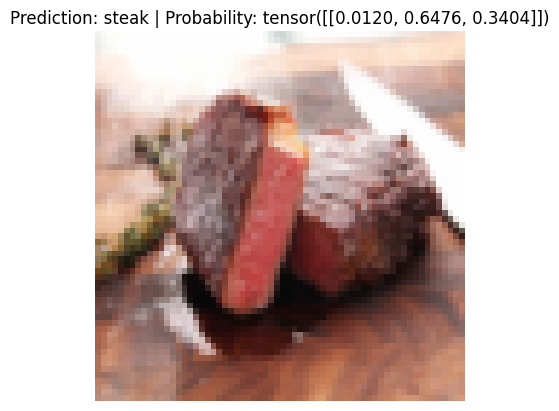

In [96]:
predict_plot_image(model_2, 
                   target_path, 
                   train_dataset_20.classes, 
                   input_transform)

1. The model accurately predicts the steak and with the appropriate values for its prediction probabilities since it ranked pizza lowest, steak highest, and sushi at the middle between the two other classes.

2. If I were to improve the model then I would find more data for it to train on. In addition, I'd expand on the number of hidden units. Perhaps try to change the optimizer from Adam to SGD and see the difference between the two. 